In [3]:
import torch
from torch import nn 
import torchvision 
from  torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader,TensorDataset
import time
import numpy as np

import matplotlib.pyplot as plt 
import icecream as ic
from IPython.display import clear_output,display

train_data = datasets.FashionMNIST(root='data',train=True,download=True,transform=ToTensor(),target_transform=None)
test_data = datasets.FashionMNIST(root='data',train=False,download=True,transform=ToTensor())

device = 'cuda'
print(device)
train_loader = DataLoader(train_data,batch_size=64,shuffle=True)
test_loader = DataLoader(test_data,batch_size=64,shuffle=False)






cuda


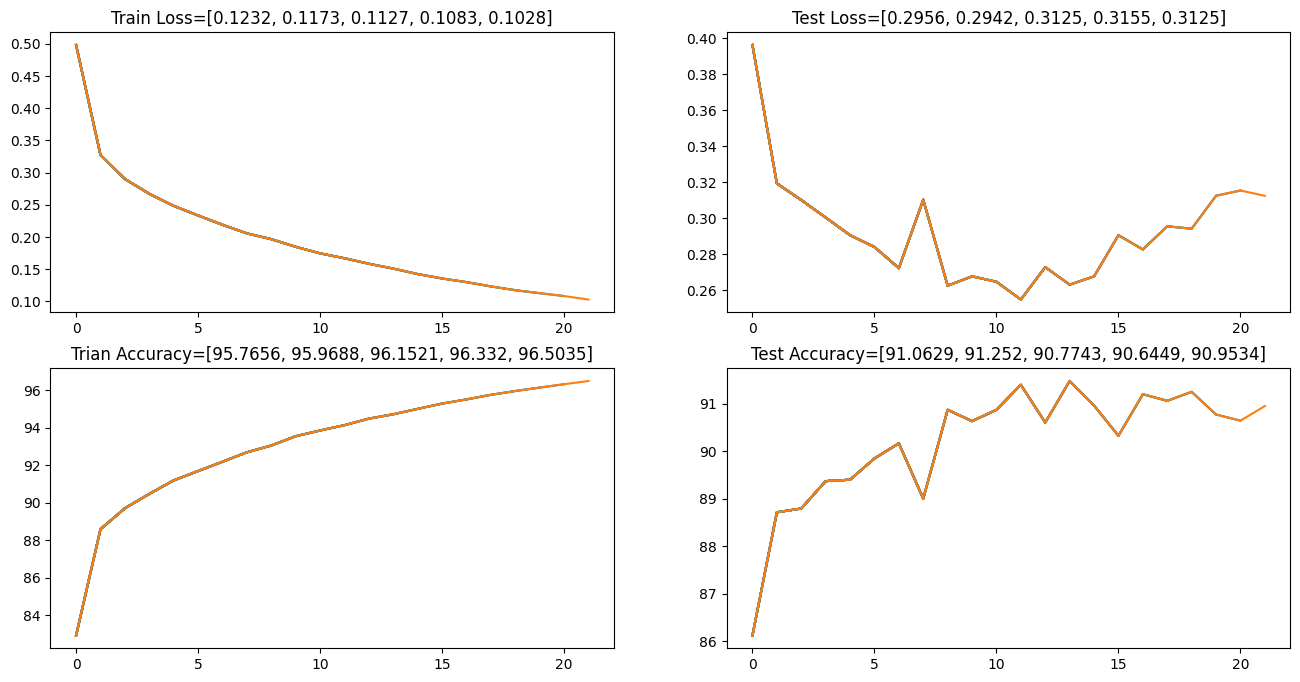

-------epoch------:21 time:6.08s
Early stopping! No improvement for 10 consecutive epochs.
train loss:[0.3962, 0.3194, 0.3102, 0.3005, 0.2906, 0.2841, 0.2723, 0.3103, 0.2626, 0.2678, 0.2648, 0.2549, 0.2729, 0.2632, 0.2677, 0.2906, 0.2827, 0.2956, 0.2942, 0.3125, 0.3155, 0.3125]
test loss:[0.3962, 0.3194, 0.3102, 0.3005, 0.2906, 0.2841, 0.2723, 0.3103, 0.2626, 0.2678, 0.2648, 0.2549, 0.2729, 0.2632, 0.2677, 0.2906, 0.2827, 0.2956, 0.2942, 0.3125, 0.3155, 0.3125]


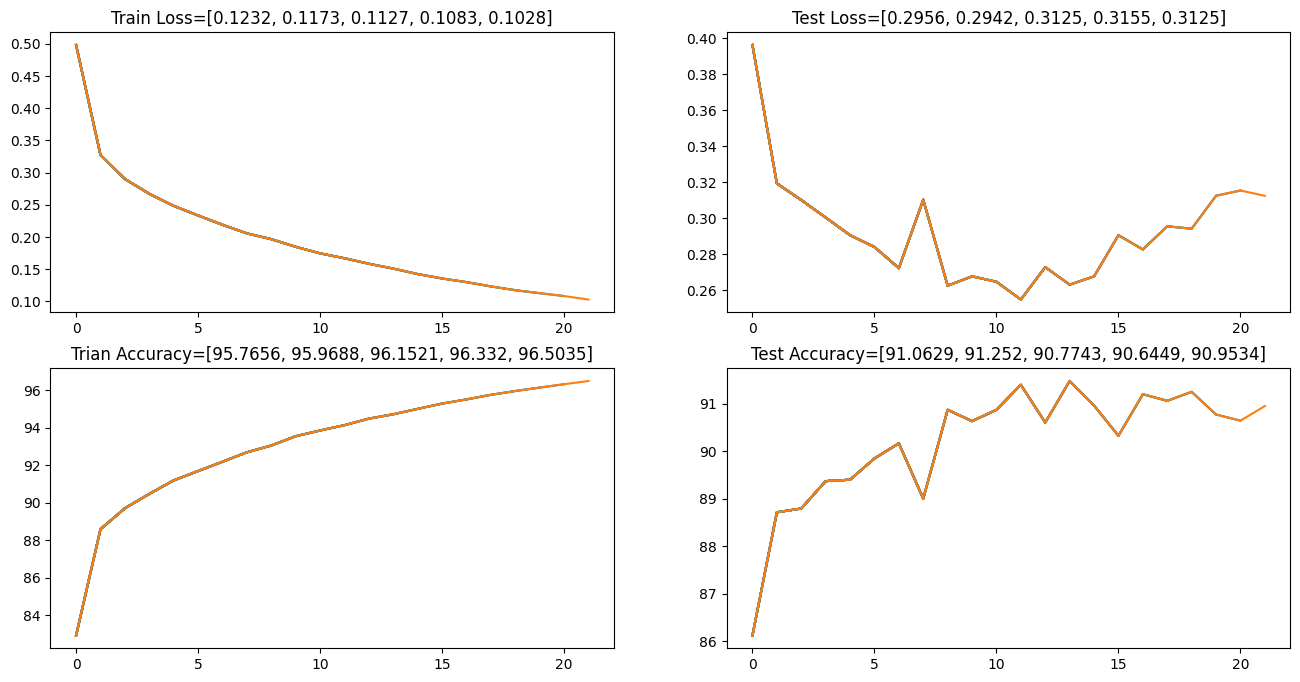

In [4]:
module = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 *28,64),
    nn.BatchNorm1d(num_features=64),
    nn.ReLU(),
    nn.Linear(64,16),
    nn.BatchNorm1d(num_features=16),
    nn.ReLU(),
    nn.Linear(16,len(train_data.classes)),
    #nn.Softmax(dim=1)
)

class CustomModelWithConv(nn.Module):
    def __init__(self, weight_decay=1e-4):
        super(CustomModelWithConv, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()

        self.classifier = nn.Sequential(
            nn.Linear(32 * 14 * 14, 32),
            nn.ReLU(),
            nn.Linear(32, len(train_data.classes))
        )

        # 添加L2正则化
        self.weight_decay = weight_decay

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

    
    def l2_regularization222(self):
        l2_reg = torch.tensor(0.0).to(device)
        for param in self.parameters():
            if len(param.shape) > 1:  # 仅对权重矩阵应用 L2 正则化
                l2_reg += torch.norm(param, p='fro')  # 计算 Frobenius 范数
        return self.weight_decay * l2_reg
    
module = CustomModelWithConv()
    
loss_fn = nn.CrossEntropyLoss()
from torch.optim.lr_scheduler import StepLR
optimizer = torch.optim.Adam(params=module.parameters(),lr = 0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=20, gamma=0.2)

from util import accuracy_fn,train_step,test_step



best_loss = float('inf')
patience= 10
current_patience = 0
epochs = 100
train_result = []
test_result = []

test_losses= []
test_accs = []
train_losses = []
train_accs = []

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw={'height_ratios': [1, 1]})
#plt.subplots_adjust(wspace=0.5, hspace=0.5)

for epoch in range(epochs):
    start_time = time.time()
    train_loss,train_acc = train_step(module=module,data_loader=train_loader,loss_fn=loss_fn,optimizer=optimizer,device=device,accuracy_fn=accuracy_fn)
    #scheduler.step()
    test_loss,test_acc = test_step(module=module,data_loader= test_loader,loss_fn= loss_fn,device=device,accuracy_fn=accuracy_fn)
    if test_loss < best_loss:
        best_loss = test_loss
        current_patience = 0
    else:
        current_patience += 1

    train_result.append((epoch,train_loss,train_acc))
    train_losses.append(train_loss.detach().cpu().numpy())
    #train_losses.append(train_loss.cpu())
    train_accs.append(train_acc)
    test_result.append((epoch,test_loss,test_acc))
    test_losses.append(test_loss.detach().cpu().numpy())
    test_accs.append(test_acc)

    clear_output(wait=True)
    ax1.plot(train_losses, )
    ax2.plot(test_losses, )
    ax3.plot(train_accs)
    ax4.plot(test_accs)
    ax1.set_title(f'Train Loss={[ np.round(item,4) for item in train_losses[-5:]]}')
    ax2.set_title(f'Test Loss={[ np.round(item,4) for item in test_losses[-5:]]}')
    ax3.set_title(f'Trian Accuracy={[ round(item,4) for item in train_accs[-5:]]}')
    ax4.set_title(f'Test Accuracy={[ round(item,4) for item in test_accs[-5:]]}')
    display(fig)
    end_time = time.time()
    print(f'-------epoch------:{epoch} time:{(end_time - start_time):.2f}s')
    if current_patience == patience:
        print(f'Early stopping! No improvement for {patience} consecutive epochs.')
        print(f"train loss:{[ np.round(item,4) for item in test_losses]}")
        print(f"test loss:{[ np.round(item,4) for item in test_losses]}")
        break

    if epoch % 10 == 0:
        print(f"last 10 loss:{[ np.round(item,4) for item in test_losses[-10:]]}")
plt.ioff()

In [5]:
epoch_lable,loss_lable,acc_lable = zip(*train_result)
loss_lable = [item.detach().cpu().numpy() for item in loss_lable]
plt.figure(figsize=(20, 4))
plt.plot(epoch_lable, loss_lable, label='Train Loss', marker='o')
#plt.plot(epoch_lable, acc_lable, label='Train acc', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [6]:
plt.figure(figsize=(20, 4))
plt.plot(epoch_lable, acc_lable, label='Train acc', marker='s')
plt.xlabel('Epoch')
plt.ylabel('ACC')
plt.legend()

In [7]:
test_epoch_lable,test_loss_lable,test_acc_lable = zip(*test_result)
test_loss_lable = [item.detach().cpu().numpy() for item in test_loss_lable]
plt.figure(figsize=(20, 4))
plt.plot(test_epoch_lable, test_loss_lable, label='Test Loss', marker='o')
#plt.plot(test_epoch_lable, test_acc_lable, label='Test acc', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [8]:
plt.figure(figsize=(20, 4))
#plt.plot(epoch_lable, loss_lable, label='Test Loss', marker='o')
plt.plot(test_epoch_lable, test_acc_lable, label='Test acc', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [9]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label);


Image shape: torch.Size([1, 28, 28])


In [10]:
row, col = 4,4
figure = plt.figure(figsize=(9,9))
class_names = train_data.classes
for i in range(1,row* col+1):
    index = torch.randint(0,len(train_data),size=[1]).item()
    image, label = train_data[index]
    figure.add_subplot(row, col, i)
    plt.imshow(image.squeeze())
    plt.title(class_names[label])
    plt.axis(False);
    

In [11]:
import sys
sys.executable

#train_step(module=module0,data_loader=train_loader,loss_fn=loss_fn,optimizer=optimizer,device=device)

'c:\\Users\\syuyu\\AppData\\Local\\Programs\\Python\\Python310\\python.exe'